# Mining Data Streams


## Sampling

- Reservoir
    fixed size
    pick new sample with probability s/n
    replace uniformly, all s samples are equally likely to get replaced

## Filtering
- First cut
    hashed bit array
- Bloom filter
    using n hash functions to verify that x is in S
    optimal k = n/m *ln(2)

## Algorithms on stream
- unique elements
- occurence
    - moments
        - 0 - distinct values
        - 1 - stream length
        - 2 - surprise
        - k - Sum of (m_j)^k = n(c_k - ( c - 1)^k )




implementing: [In-Core Computation of Geometric Centralities with
HyperBall:
A Hundred Billion Nodes and Beyond](https://arxiv.org/pdf/1308.2144v2)
1. Flajolet-Martin algorithm
2. Streaming graph algorithm



HyperLogLog

HyperBall


In [106]:
# HyperLogLog counter

from mmh3 import hash

def _hash(x):
    return hash(x)

def _leading_zeros(x):
    if isinstance(x, bytes):
        # Convert bytes to string and count leading zeros
        return str(x, 'ascii').count('0', 0, str(x, 'ascii').find('1'))
    elif isinstance(x, int):
        # Convert integer to binary string and count leading zeros
        return bin(x)[2:].count('0', 0, bin(x)[2:].find('1'))

    raise ValueError(f"Unsupported type: {type(x)}")

def p_plus_one(x):
    return _leading_zeros(x) + 1

class Counter:
    def __init__(self, b):
        self.p = (2**b)
        self.b = b
        self.M = [0] * self.p
        self.alpha_p = 0.7213 / (1 + 1.079 / self.p) # https://algo.inria.fr/flajolet/Publications/FlFuGaMe07.pdf p.140 (14)
    
    def set_m(self, m):
        self.M = m
        return self

    def add(self, x, verbose=False):
        h = _hash(str(x).encode('utf-8'))
        # Get bucket index using first b bits
        i = h & ((1 << self.b) - 1)
        # Get remaining bits
        w = h >> self.b
        # count leading zeros
        p = p_plus_one(w)
        self.M[i] = max(self.M[i], p)
        
        if verbose: print(f"h: {h:032b}, i: {i:{self.b}b}, w: {w:{32-self.b}b}, p_+1: {p}, M[i]: {self.M[i]}")


    def size(self):
        Z = sum(2**(-m) for m in self.M)
        return self.alpha_p * self.p**2 * 1/Z
    
    def _repr_(self):
        return f"Counter(b={self.b}, p={self.p}, M={self.M})"
    
    


In [79]:
c = Counter(4)

In [80]:
c.add(500, True)
c.size()


h: 00000110000101001011110011100110, i:  110, w:      11000010100101111001110, p_+1: 1, M[i]: 1


11.160450959393634

In [81]:
c._repr_()

'Counter(b=4, p=16, M=[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])'

In [82]:
c.add(100)
c.size()


11.53246599137342

In [83]:
c._repr_()

'Counter(b=4, p=16, M=[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1])'

In [84]:
from itertools import islice

def process_data(filename, n=None):
    data = []
    with open(filename, 'r') as f:
        # If n is None, islice will read until the end
        for line in islice(f, n):
            if line.strip().startswith('#'):
                continue
            source, target = map(int, line.strip().split())
            data.append((source, target))
    return data
    
class Graph:
    def __init__(self, data):
        self.build(data)
    
    def build(self, data):
        self.adj_list = {}
        self.nodes = set()
        
        # Build the graph
        for source, target in data:
            self.nodes.add(source)
            self.nodes.add(target)
            
            if source not in self.adj_list:
                self.adj_list[source] = set()
            self.adj_list[source].add(target)
            
        # Add node mapping
        self.node_to_idx = {node: idx for idx, node in enumerate(sorted(self.nodes))}
        self.idx_to_node = {idx: node for node, idx in self.node_to_idx.items()}
    
    def neighbors(self, idx):
        """Return neighbors of a node (using internal index)"""
        node = self.idx_to_node[idx]
        return {self.node_to_idx[n] for n in self.adj_list.get(node, set())}
    
    def num_nodes(self):
        """Return total number of nodes"""
        return len(self.nodes)
        
        


In [97]:
data = process_data('data/web-BerkStan.txt', n=50000)

In [98]:

G = Graph(data)


In [87]:


import os

class Disk:
    def __init__(self, path):
        self.path = path
        self.delimiter = '---'
        
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(self.path), exist_ok=True)
        
        # create path if doesn't exist
        if not os.path.exists(self.path):
            with open(self.path, 'w') as f:
                f.write('')
        
        self.clear()
    
    def clear(self):
        with open(self.path, 'w') as f:
            f.write('')

    def write_single_vc(self, v, c):
        """Write a single edge to disk"""
        with open(self.path, 'a') as f:
            # Convert list to comma-separated string
            c_str = ','.join(map(str, c))
            f.write(f"{v}{self.delimiter}{c_str}\n")
    
    def read_edges(self):
        """Read edges from disk and return as list of tuples"""
        edges = []
        with open(self.path, 'r') as f:
            for line in f:
                v, c_str = line.strip().split(self.delimiter)
                # Convert string back to list of integers
                c = list(map(int, c_str.split(',')))
                edges.append((int(v), c))
        return edges

def union(a:Counter, b:Counter):
    for i in range(a.p):
        a.M[i] = max(a.M[i], b.M[i])
    return a



In [107]:

# HyperBall algorithm
D = Disk('tmp/counts.txt')
B = 4
N = G.num_nodes()
MAX_STEPS = 100

# intialize counters
c = [Counter(B) for _ in range(N)]

# add self to each counter
for v in range(N):
    c[v].add(v)
    

# history
counter_sizes_t = []

t = 0   
while t < MAX_STEPS:
    counter_sizes_t.append([c[v].size() for v in range(N)])

    for v in range(N):
        a = c[v]
        for w in G.neighbors(v):
            a = union(c[w], a)
        
        # write to disk
        D.write_single_vc(v, a.M)
    
    # read from disk
    vms = D.read_edges()
    D.clear()
    
    # update counters if changed
    changed = False
    for v, m in vms:

        if c[v].M != m:
            c[v].set_m(m)
            changed = True
        
    
    
    if not changed:
        break
    t += 1


In [118]:
from tqdm import tqdm

# HyperBall algorithm
def hyperball(G, B=4, MAX_STEPS=100, use_disk=False):
    D = Disk('tmp/counts.txt') if use_disk else None
    N = G.num_nodes()
    
    # initialize counters
    c = [Counter(B) for _ in range(N)]
    for v in range(N):
        c[v].add(v)
    
    # history
    counter_sizes_t = []
    
    for t in tqdm(range(MAX_STEPS), desc="HyperBall"):
        counter_sizes_t.append([c[v].size() for v in range(N)])
        
        if use_disk:
            # Disk-based version
            for v in range(N):
                a = c[v]
                for w in G.neighbors(v):
                    a = union(c[w], a)
                D.write_single_vc(v, a.M)
            
            vms = D.read_edges()
            D.clear()
            
            # update counters if changed
            changed = False
            for v, m in vms:
                if c[v].M != m:
                    c[v].set_m(m)
                    changed = True
        else:
            # In-memory version
            new_counters = []
            changed = False
            
            for v in range(N):
                a = Counter(B)
                a.set_m(c[v].M.copy())  # Start with current counter
                for w in G.neighbors(v):
                    a = union(c[w], a)
                new_counters.append(a)
                
                if a.M != c[v].M:
                    changed = True
            
            c = new_counters
            
        if not changed:
            print(f"Converged at step {t}")
            break
    
    return c, counter_sizes_t

data = process_data('data/web-BerkStan.txt', n=500000)
G = Graph(data)
c, counter_sizes_t = hyperball(G, B=4, MAX_STEPS=100, use_disk=False)


HyperBall:   4%|▍         | 4/100 [00:04<01:37,  1.01s/it]

Converged at step 4


In [122]:
G.num_nodes()

30641

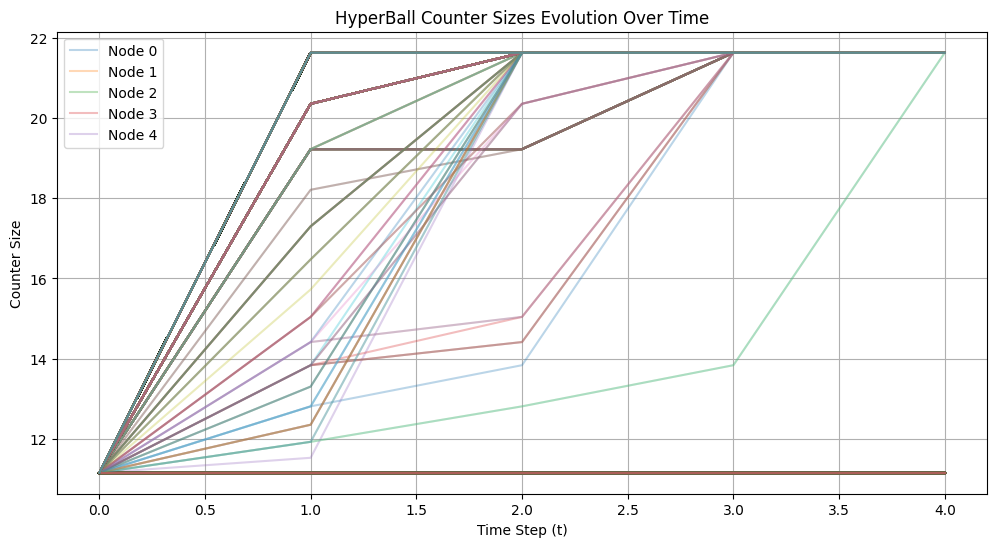

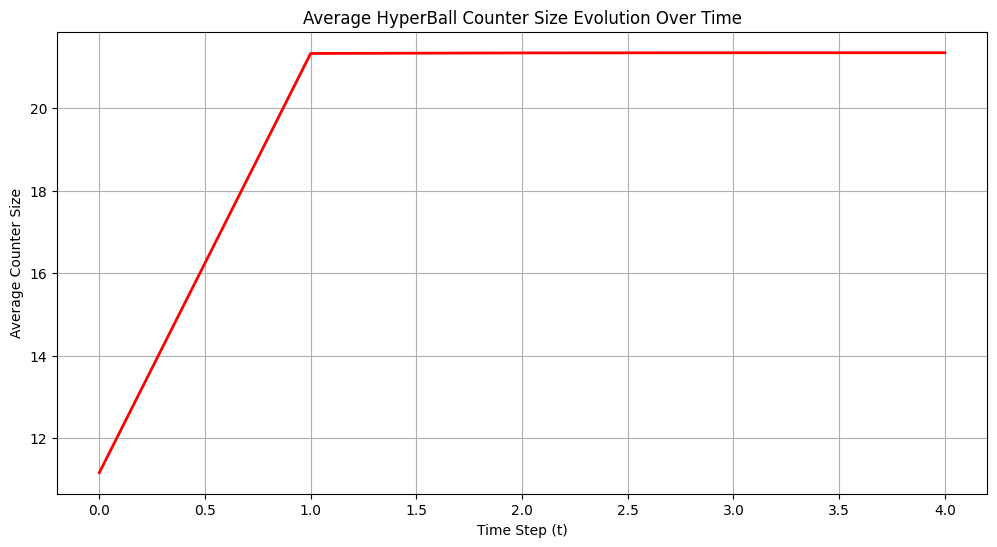

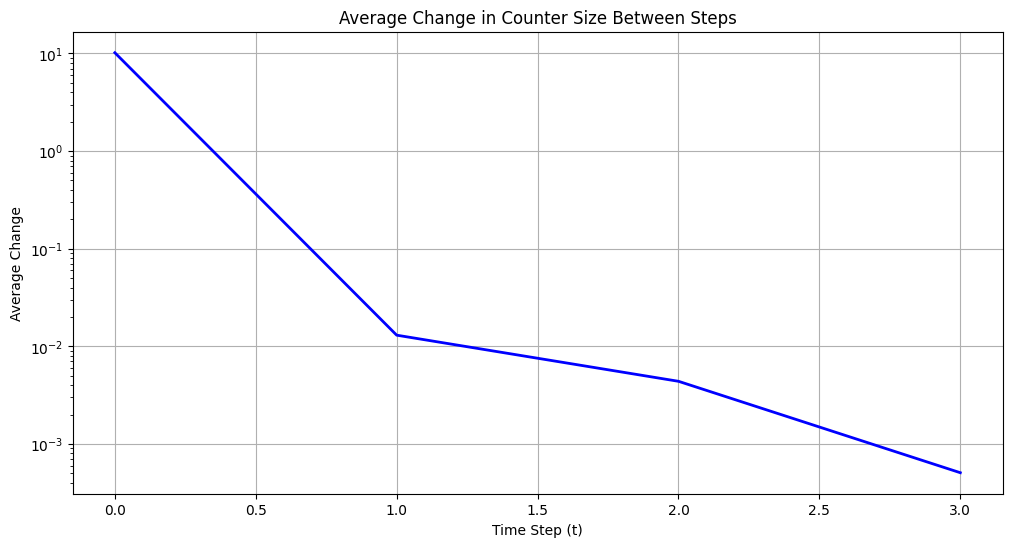

In [123]:
import matplotlib.pyplot as plt
import numpy as np

def plot_hyperball_evolution(counter_sizes_t):
    # Plot individual node trajectories
    plt.figure(figsize=(12, 6))
    num_nodes = len(counter_sizes_t[0])
    
    for node in range(num_nodes):
        node_sizes = [sizes[node] for sizes in counter_sizes_t]
        plt.plot(node_sizes, alpha=0.3, 
                 label=f'Node {node}' if node < 5 else "")

    plt.xlabel('Time Step (t)')
    plt.ylabel('Counter Size')
    plt.title('HyperBall Counter Sizes Evolution Over Time')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

    # Plot average trajectory
    plt.figure(figsize=(12, 6))
    avg_sizes = [np.mean(sizes) for sizes in counter_sizes_t]
    plt.plot(avg_sizes, 'r-', linewidth=2)
    plt.xlabel('Time Step (t)')
    plt.ylabel('Average Counter Size')
    plt.title('Average HyperBall Counter Size Evolution Over Time')
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(12, 6))
    avg_sizes = [np.mean(sizes) for sizes in counter_sizes_t]
    # Calculate changes between consecutive steps
    avg_changes = [abs(avg_sizes[i+1] - avg_sizes[i]) for i in range(len(avg_sizes)-1)]
    
    plt.plot(avg_changes, 'b-', linewidth=2)
    plt.xlabel('Time Step (t)')
    plt.ylabel('Average Change')
    plt.title('Average Change in Counter Size Between Steps')
    plt.grid(True)
    plt.yscale('log')  # Using log scale as changes might vary by orders of magnitude
    plt.show()
    

# Usage:
plot_hyperball_evolution(counter_sizes_t)